In [2]:
import torch

models = torch.load('model.pt')
models.keys()

dict_keys(['model', 'ema_model', 'model_00', 'model_01', 'model_02', 'model_03', 'model_04', 'model_05', 'ema_model_0', 'model_10', 'model_11', 'model_12', 'model_13', 'model_14', 'model_15', 'ema_model_1', 'model_20', 'model_21', 'model_22', 'model_23', 'model_24', 'model_25', 'ema_model_2', 'model_30', 'model_31', 'model_32', 'model_33', 'model_34', 'model_35', 'ema_model_3', 'model_40', 'model_41', 'model_42', 'model_43', 'model_44', 'model_45', 'ema_model_4'])

In [3]:
import pandas as pd

TEST_DATA = 'input/test_private_expanded.csv'
test = pd.read_csv(TEST_DATA, index_col='id')
test.head()

,comment_text,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,...,other_religion,black,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability
id,,,,,,,,,,,,,,,,,,,,,
7097320,[ Integrity means that you pay your debts.]\n\...,2017-09-13 20:12:01.484121+00,21,5945023.0,376974,approved,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7097321,This is malfeasance by the Administrator and t...,2017-05-17 07:01:51.902566+00,55,NaN,335003,approved,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7097322,@Rmiller101 - Spoken like a true elitist. But ...,2016-12-02 17:12:12.920957+00,54,649389.0,154126,approved,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7097323,"Paul: Thank you for your kind words. I do, in...",2017-04-21 14:58:05.474657+00,13,5158666.0,328376,approved,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7097324,Sorry you missed high school. Eisenhower sent ...,2017-10-01 19:43:12.373229+00,102,6061626.0,383983,approved,1,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
import numpy as np
from torch.utils.data import Dataset, DataLoader, Sampler
import string
import re
import json
from sklearn.utils import shuffle
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer

max_len = 220
batch_size = 512
seed = 1029
EMBEDDING_FASTTEXT = './input/crawl-300d-2M.vec'
max_features = 100000


ps = PorterStemmer()
lc = LancasterStemmer()
sb = SnowballStemmer('english')

# preprocessing
misspell_dict = {"aren't": "are not", "can't": "cannot", "couldn't": "could not",
                 "didn't": "did not", "doesn't": "does not", "don't": "do not",
                 "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                 "he'd": "he would", "he'll": "he will", "he's": "he is",
                 "i'd": "I had", "i'll": "I will", "i'm": "I am", "isn't": "is not",
                 "it's": "it is", "it'll": "it will", "i've": "I have", "let's": "let us",
                 "mightn't": "might not", "mustn't": "must not", "shan't": "shall not",
                 "she'd": "she would", "she'll": "she will", "she's": "she is",
                 "shouldn't": "should not", "that's": "that is", "there's": "there is",
                 "they'd": "they would", "they'll": "they will", "they're": "they are",
                 "they've": "they have", "we'd": "we would", "we're": "we are",
                 "weren't": "were not", "we've": "we have", "what'll": "what will",
                 "what're": "what are", "what's": "what is", "what've": "what have",
                 "where's": "where is", "who'd": "who would", "who'll": "who will",
                 "who're": "who are", "who's": "who is", "who've": "who have",
                 "won't": "will not", "wouldn't": "would not", "you'd": "you would",
                 "you'll": "you will", "you're": "you are", "you've": "you have",
                 "'re": " are", "wasn't": "was not", "we'll": " will", "tryin'": "trying"}


def _get_misspell(misspell_dict):
    misspell_re = re.compile('(%s)' % '|'.join(misspell_dict.keys()))
    return misspell_dict, misspell_re


def replace_typical_misspell(text):
    misspellings, misspellings_re = _get_misspell(misspell_dict)

    def replace(match):
        return misspellings[match.group(0)]

    return misspellings_re.sub(replace, text)
    

puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']',
          '>', '%', '=', '#', '*', '+', '\\', '•', '~', '@', '£', '·', '_', '{', '}', '©', '^',
          '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 'Â', '█',
          '½', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶',
          '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼',
          '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
          'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪',
          '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√']


def clean_text(x):
    x = str(x)
    for punct in puncts + list(string.punctuation):
        if punct in x:
            x = x.replace(punct, f' {punct} ')
    return x


def clean_numbers(x):
    return re.sub(r'\d+', ' ', x)

# load dataframe
def load_and_prec(df):
    test = df
    # lower
    test['comment_text'] = test['comment_text'].str.lower()

    # clean misspellings
    test['comment_text'] = test['comment_text'].apply(replace_typical_misspell)

    # clean the text
    test['comment_text'] = test['comment_text'].apply(clean_text)

    # clean numbers
    test['comment_text'] = test['comment_text'].apply(clean_numbers)
    
    # strip
    test['comment_text'] = test['comment_text'].str.strip()
    
    # replace blank with nan
    test['comment_text'].replace('', np.nan, inplace=True)

    
    # fill up the missing values
    test_x = test['comment_text'].fillna('_##_').values
    
    # get the target values
    identity_columns = [
        'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
        'muslim', 'black', 'white', 'psychiatric_or_mental_illness']



    return test_x

from torch import nn

class NeuralNet(nn.Module):

    def __init__(self, embedding_matrix):
        super(NeuralNet, self).__init__()

        lstm_hidden_size = 120
        gru_hidden_size = 60
        self.gru_hidden_size = gru_hidden_size

        self.embedding = nn.Embedding(*embedding_matrix.shape)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = nn.Dropout2d(0.2)

        self.lstm = nn.LSTM(embedding_matrix.shape[1], lstm_hidden_size, bidirectional=True, batch_first=True)
        self.gru = nn.GRU(lstm_hidden_size * 2, gru_hidden_size, bidirectional=True, batch_first=True)

        self.linear = nn.Linear(gru_hidden_size * 6, 20)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(20, 1)
        
    def apply_spatial_dropout(self, h_embedding):
        h_embedding = h_embedding.transpose(1, 2).unsqueeze(2)
        h_embedding = self.embedding_dropout(h_embedding).squeeze(2).transpose(1, 2)
        return h_embedding

    def forward(self, x):
        h_embedding = self.embedding(x)
        h_embedding = self.apply_spatial_dropout(h_embedding)

        h_lstm, _ = self.lstm(h_embedding)
        h_gru, hh_gru = self.gru(h_lstm)

        hh_gru = hh_gru.view(-1, self.gru_hidden_size * 2)

        avg_pool = torch.mean(h_gru, 1)
        max_pool, _ = torch.max(h_gru, 1)

        conc = torch.cat((hh_gru, avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)

        return out

class BucketSampler(Sampler):

    def __init__(self, data_source, sort_keys, bucket_size=None, batch_size=1048, shuffle_data=True):
        super().__init__(data_source)
        self.shuffle = shuffle_data
        self.batch_size = batch_size
        self.sort_keys = sort_keys
        self.bucket_size = bucket_size if bucket_size is not None else len(sort_keys)
        self.weights = None

        if not shuffle_data:
            self.index = self.prepare_buckets()
        else:
            self.index = None

    def set_weights(self, weights):
        assert weights >= 0
        total = np.sum(weights)
        if total != 1:
            weights = weights / total
        self.weights = weights

    def __iter__(self):
        indices = None
        if self.weights is not None:
            total = len(self.sort_keys)
            indices = np.random.choice(total, (total,), p=self.weights)
        if self.shuffle:
            self.index = self.prepare_buckets(indices)
        return iter(self.index)

    def get_reverse_indexes(self):
        indexes = np.zeros((len(self.index),), dtype=np.int32)
        for i, j in enumerate(self.index):
            indexes[j] = i
        return indexes

    def __len__(self):
        return len(self.sort_keys)
        
    def prepare_buckets(self, indices=None):
        lens = - self.sort_keys
        assert self.bucket_size % self.batch_size == 0 or self.bucket_size == len(lens)

        if indices is None:
            if self.shuffle:
                indices = shuffle(np.arange(len(lens), dtype=np.int32))
                lens = lens[indices]
            else:
                indices = np.arange(len(lens), dtype=np.int32)

        #  bucket iterator
        def divide_chunks(l, n):
            if n == len(l):
                yield np.arange(len(l), dtype=np.int32), l
            else:
                # looping till length l
                for i in range(0, len(l), n):
                    data = l[i:i + n]
                    yield np.arange(i, i + len(data), dtype=np.int32), data
    
        new_indices = []
        extra_batch = None
        for chunk_index, chunk in divide_chunks(lens, self.bucket_size):
            # sort indices in bucket by descending order of length
            indices_sorted = chunk_index[np.argsort(chunk, axis=-1)]
            batches = []
            for _, batch in divide_chunks(indices_sorted, self.batch_size):
                if len(batch) == self.batch_size:
                    batches.append(batch.tolist())
                else:
                    assert extra_batch is None
                    assert batch is not None
                    extra_batch = batch
    
            # shuffling batches within buckets
            if self.shuffle:
                batches = shuffle(batches)
            for batch in batches:
                new_indices.extend(batch)
    
        if extra_batch is not None:
            new_indices.extend(extra_batch)
        return indices[new_indices]


class TextDataset(Dataset):

    def __init__(self, seqs, targets=None, maxlen=200):
        if targets is not None:
            self.targets = targets
        else:
            self.targets = np.random.randint(2, size=(len(seqs),))
        
        self.seqs = seqs
        self.maxlen = maxlen
        
    def __len__(self):
        return len(self.seqs)
        
    def get_keys(self):
        lens = np.fromiter(
            ((min(self.maxlen, len(seq))) for seq in self.seqs),
            dtype=np.int32)
        return lens
        
    def __getitem__(self, index):
        return index, self.seqs[index], self.targets[index]

def collate_fn(data):
    def _pad_sequences(seqs):
        lens = [len(seq) for seq in seqs]
        max_len = max(lens)

        padded_seqs = torch.zeros(len(seqs), max_len).long()
        for i, seq in enumerate(seqs):
            start = max_len - lens[i]
            padded_seqs[i, start:] = torch.LongTensor(seq)
        return padded_seqs

    index, seqs, targets = zip(*data)
    seqs = _pad_sequences(seqs)
    return index, seqs, torch.FloatTensor(targets)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def eval_model(model, data_loader):
    model.eval()
    preds_fold = np.zeros(len(data_loader.dataset))

    with torch.no_grad():
        for index, x_batch, y_batch in data_loader:
            x_batch = x_batch.to("cuda")
            y_batch = y_batch.to("cuda")
            y_pred = model(x_batch).detach()
            preds_fold[list(index)] = sigmoid(y_pred.cpu().numpy())[:, 0]

    return preds_fold


def tokenize(texts, vocab):

    def text2ids(text, token2id):
        return [
            token2id.get(token, len(token2id) - 1)
            for token in text.split()[:max_len]] + [0] * max(0, max_len - len(text.split()))
    
    return [
        text2ids(text, vocab['token2id'])
        for text in texts]


def load_embedding(embedding_path, word_index):

    def get_coefs(word, *arr):
        return word, np.asarray(arr, dtype='float32')

    embeddings_index = dict(get_coefs(*o.strip().split(' ')) for o in open(embedding_path))
    
    # word_index = tokenizer.word_index
    nb_words = min(max_features + 2, len(word_index))
    embedding_matrix = np.zeros((nb_words, embed_size))

    for key, i in word_index.items():
        word = key
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        word = key.lower()
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        word = key.upper()
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        word = key.capitalize()
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        word = ps.stem(key)
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        word = lc.stem(key)
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        word = sb.stem(key)
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue

    return embedding_matrix


with open('vocab.json', 'r') as f:
    vocab = json.load(f)

embedding_matrix = load_embedding(EMBEDDING_FASTTEXT, vocab['token2id'])

test_x = load_and_prec(test)
test_x = np.array(tokenize(test_x, vocab))
test_dataset = TextDataset(test_x, maxlen=max_len)
test_sampler = BucketSampler(test_dataset, test_dataset.get_keys(),
                                 batch_size=batch_size, shuffle_data=False)

test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler,
                             shuffle=False, num_workers=0, collate_fn=collate_fn)


for name in models.keys():
    new_model = NeuralNet
    models[name] = 
model = TheModelClass(*args, **kwargs)
model.load_state_dict(


def inference(comment, models):
    test_x = np.array(tokenize([comment], vocab))
    test_dataset = TextDataset(test_x, maxlen=max_len)
    test_sampler = BucketSampler(test_dataset, test_dataset.get_keys(),
                                 batch_size=batch_size, shuffle_data=False)

    test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler,
                             shuffle=False, num_workers=0, collate_fn=collate_fn)

    preds = []
    print(models)
    for name, model in models.items():
        print(name, model)
        preds.append(eval_model(model, test_loader))
    return np.mean(preds, axis=0)


inference('hello', models)


test_preds = np.zeros((len(test_x)))
test_nan_mask = test_x == '_##_'
nan_pred = 0 #train['target'][train['comment_text'].isna()].mean() # TODO: check
test_preds[test_nan_mask] = nan_pred

ema_test_preds[test_nan_mask] = nan_pred
test_preds = np.mean([test_preds, ema_test_preds], axis=0)
test['prediction'] = test_preds * 0.9 + test_y[:, 0] * 0.1


{'model': OrderedDict([('embedding.weight', tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0849, -0.0582, -0.0321,  ...,  0.0032, -0.0237, -0.0366],
        [ 0.0231,  0.0170,  0.0157,  ...,  0.0744, -0.1118,  0.0963],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.3247,  0.4427, -0.5735,  ...,  0.5473, -0.7108, -0.0904],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')), ('lstm.weight_ih_l0', tensor([[ 0.0600,  0.4442, -0.2488,  ...,  0.1114, -0.6634,  0.0779],
        [-0.1309,  1.5001, -0.1927,  ...,  0.5426,  0.8410, -0.5787],
        [-0.5749,  0.5218, -0.2604,  ..., -0.1511, -0.5596, -0.7702],
        ...,
        [-0.0527, -0.4602,  0.1256,  ..., -0.7773,  0.3943, -0.5917],
        [-0.3619, -0.0025,  0.3562,  ..., -0.7616,  0.0507, -0.1674],
        [ 0.2840,  0.6864,  0.1996,  ...,  1.2926,  0.6727, -0.0587]],
       device='cuda:0')), ('lstm.weight_

AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

# Split the data into different subpopulations and plot distributions

In [19]:
columns_to_remove = ['comment_text', 'created_date', 'publication_id', 'parent_id', 'article_id', 'rating', "identity_annotator_count", "toxicity_annotator_count"]
out_of_competition_traits = ["severe_toxicity", "obscene", "identity_attack", "insult", "threat", "sexual_explicit"]
columns_to_remove += out_of_competition_traits

subpopulations = [i for i in test.columns.to_list() if i not in columns_to_remove]
subpopulations, len(subpopulations)

(['funny',
  'wow',
  'sad',
  'likes',
  'disagree',
  'toxicity',
  'male',
  'female',
  'transgender',
  'other_gender',
  'heterosexual',
  'homosexual_gay_or_lesbian',
  'bisexual',
  'other_sexual_orientation',
  'christian',
  'jewish',
  'muslim',
  'hindu',
  'buddhist',
  'atheist',
  'other_religion',
  'black',
  'white',
  'asian',
  'latino',
  'other_race_or_ethnicity',
  'physical_disability',
  'intellectual_or_learning_disability',
  'psychiatric_or_mental_illness',
  'other_disability'],
 30)

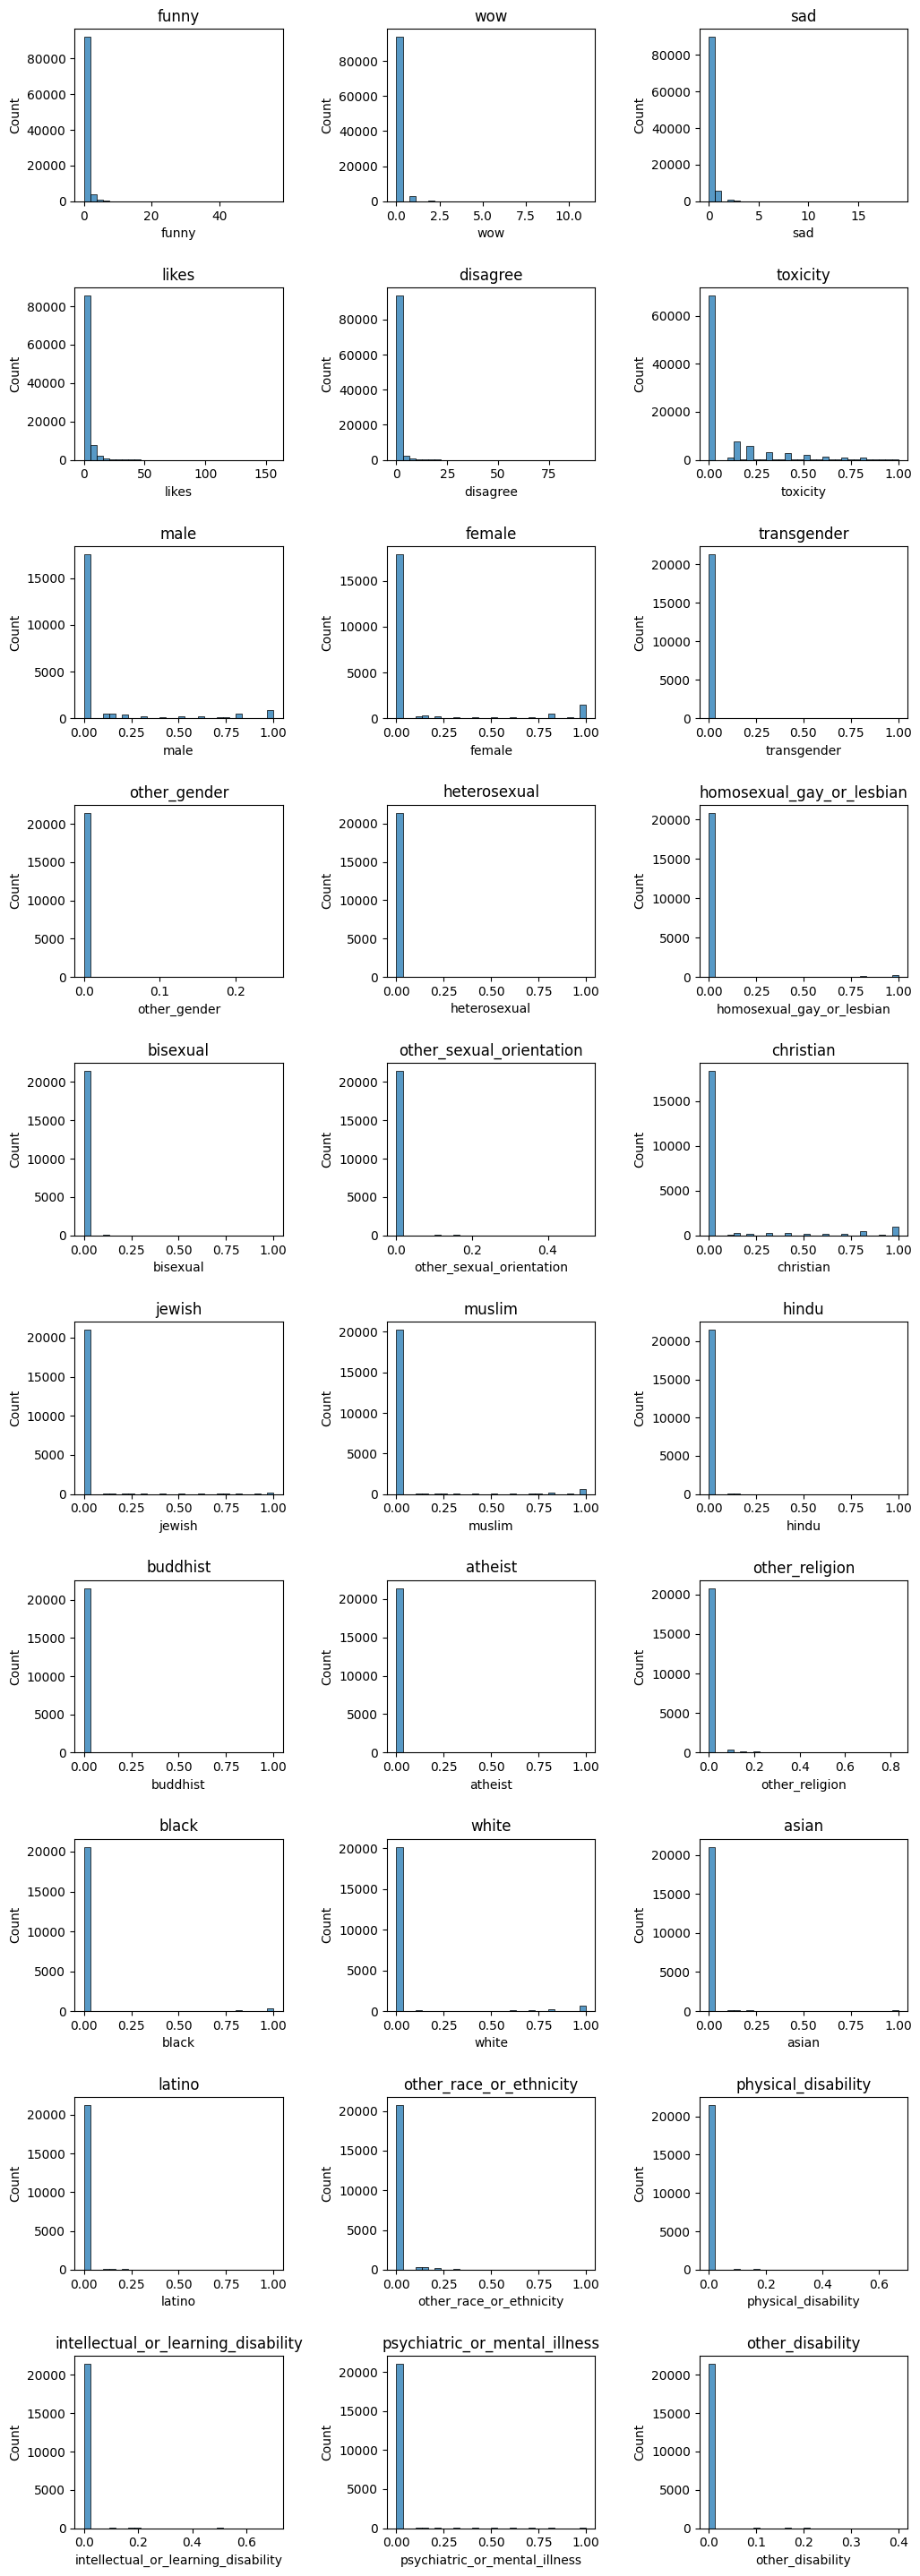

In [30]:
# We’ll split our data into different subpopulations and plot distributions in Colab.

import matplotlib.pyplot as plt
import seaborn as sns

plot_columns = 3
plot_rows = len(subpopulations) // plot_columns + 1

plt.figure(figsize=(12, 40))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
for i, subpopulation in enumerate(subpopulations):
    plt.subplot(plot_rows, plot_columns, i+1)
    sns.histplot(test[subpopulation], bins=30)#, kde=True)
    plt.title(subpopulation)

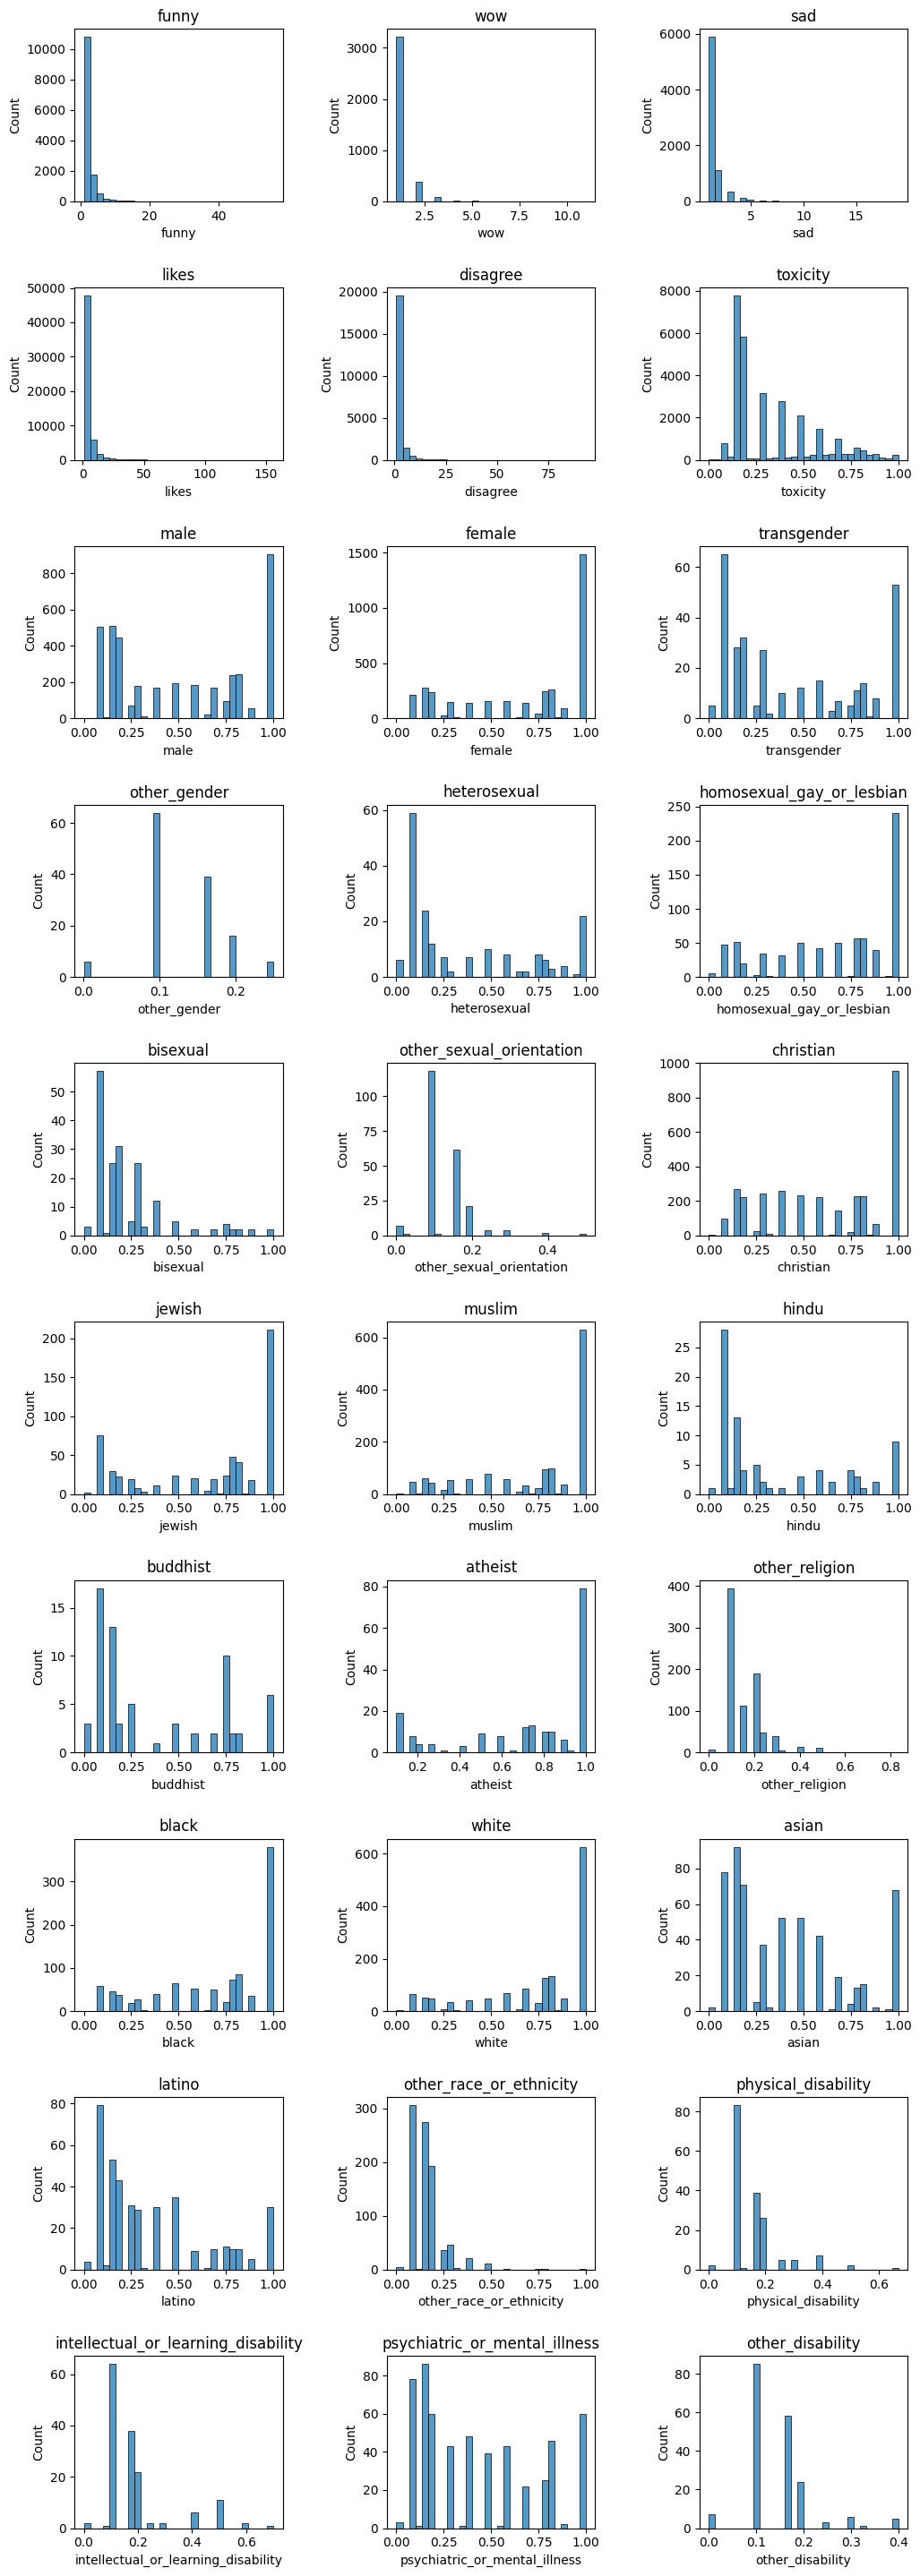

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

plot_columns = 3
plot_rows = len(subpopulations) // plot_columns + 1

plt.figure(figsize=(12, 40))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
for i, subpopulation in enumerate(subpopulations):
    plt.subplot(plot_rows, plot_columns, i+1)
    # get number of bins 
    n_bins = 30 #test[subpopulation][test[subpopulation] != test[subpopulation].min()].nunique()
    sns.histplot(test[subpopulation][test[subpopulation] != test[subpopulation].min()], bins=n_bins)#, kde=True)
    plt.title(subpopulation)

In [47]:
# percent of values that are 0
(test[subpopulations] == 0).mean()

funny                                  0.861159
wow                                    0.961683
sad                                    0.921948
likes                                  0.412916
disagree                               0.773962
toxicity                               0.701510
male                                   0.180425
female                                 0.184001
transgender                            0.218598
other_gender                           0.220366
heterosexual                           0.219831
homosexual_gay_or_lesbian              0.214190
bisexual                               0.219831
other_sexual_orientation               0.219441
christian                              0.188471
jewish                                 0.215732
muslim                                 0.207994
hindu                                  0.220849
buddhist                               0.221003
atheist                                0.219780
other_religion                         0

In [ ]:
# as we can see, most of the values are 0,

<Axes: >

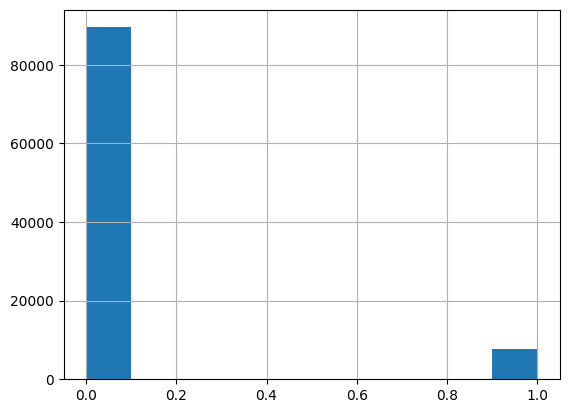

In [52]:
(test["toxicity"] >= 0.5).astype(int).hist()